# Final Exam Assignment (40 points - Total of 45 is Possible)
## Due December 7, 2022, @ 8:00 am
Note that there will be no extensions given for this assignment as there is a tight timeline for grading. 

For this assignment, I have provided each of you with your own training dataset. Your goal is to train a deep neural network to uncover the code image provided to you. 

I will provide you with instructions throughout. 

In [1]:
# Add your import statements here
import os
import numpy as np
import urllib
import time
import sys
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader
from torch import nn
import matplotlib.pyplot as plt

In [2]:
# This is a tool I have provided you to help you download your file.

def download_file(url, filename):
    """
    A function that downloads the data file from a URL
    Parameters
    ----------
    url : string
        url where the file to download is located
    filename : string
        location where to save the file
    reporthook : function
        callback to display the download progress
    """
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url, filename, reporthook)
        
def reporthook(count, block_size, total_size):
    """
    A function that displays the status and speed of the download
    """

    global start_time
    if count == 0:
        start_time = time.time()
        return
    duration = time.time() - start_time
    progress_size = int(count * block_size)
    speed = int(progress_size / (1024 * duration + 0.0001))
    percent = int(count * block_size * 100 / total_size)
    sys.stdout.write("\r...%d%%, %d MB, %d KB/s, %d seconds passed" %
                     (percent, progress_size / (1024 * 1024), speed, duration))
    sys.stdout.flush()

In [3]:
# You can download your file by typing your first name into the name block
# The name used is the first part of your first name as listed in BB learn
# If you have problems downloading the data please reach out to me

name = 'Lauren'
download_file(f'https://zenodo.org/record/7339649/files/data_{name}.npz?download=1','data.npz')

## Loading the Data (3 points)
The data is provided to you as a compressed NumPy array saved as 'data.npz'. When working with real data you might need to figure out how data is stored. Use the information on 'npz' files to figure out what data you have. The data file contains three NumPy arrays. 
1. The features for the training dataset
2. The regression values for the training dataset
3. The validation features that contain your code

In [4]:
with np.load('data.npz', allow_pickle=True) as data:
    training_feat = data['training_feat']   #features for training dataset
    training_true = data['training_true']   #regression values for training dataset
    validation_feat = data['validation_feat'] #validation features that contain your code

#check sizes
print("Training Features: ", training_feat.shape)
print("Regression Values: ", training_true.shape)
print("Validation Features: ", validation_feat.shape)     

Training Features:  (100000, 30)
Regression Values:  (100000, 3)
Validation Features:  (65536, 30)


## Preprocessing the Data (5 points)

You should explore the data and figure out the best way to preprocess the data. 

Hints: 
1. For the regression values, these at the end will represent colors in RGB space from [0,1]. It is recommended to use a max-min scalar between 0 and 1. 
2. For the training features, you should look at the data and determine the best scaling method. Look at our class notes for a reminder of what other scaler might be useful. 

In [5]:
#Regression Values, min-max scalar
mm_scaler = MinMaxScaler()
scaled_training_true = mm_scaler.fit_transform(training_true)   

#Training features, standard scaler
s_scaler =  StandardScaler()
scaled_training_feat = s_scaler.fit_transform(training_feat)

## Building the Dataset (5 points)

When training neural networks it is important to build a dataset that allows the machinery to sample the data. This also can be used to conduct some preprocessing of the data to make it work with PyTorch. 

I have provided you with the framework for a Dataset Class. 

You should:
1. Convert the x and y data to a tensor 'float32' and put it on the GPU.
2. Save the len of the data
3. Add the code so when `__getitem__` is called it returns the x and y values
3. make it so `__len__` returns the lenght when calle


In [6]:
class Data(): #TODO: what is Dataset inheritance in the copied code
  '''Dataset Class to store the samples and their corresponding labels, 
  and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.
  '''

  def __init__(self, X: np.ndarray, y: np.ndarray, device = 'cuda') -> None:

    # need to convert float64 to float32 else 
    # will get the following error
    # RuntimeError: expected scalar type Double but found Float
    self.X = X.astype(np.float32)
    self.y = y.astype(np.float32)
    self.len = len(self.X)
  
  def __getitem__(self, index: int) -> tuple:
    return self.X[index], self.y[index]

  def __len__(self) -> int:
    return self.len

## Train-test Split (3 points)

1. You should conduct a train-test split of the training data so you can make sure that your model does not overfit the data. A good ratio is 66/33 train 
2. You should instantiate the training dataset using the data class implemented above.


In [7]:
#Split train/test and put into Data object
X_train, X_test, y_train, y_test = train_test_split(scaled_training_feat, scaled_training_true, test_size = 0.33, random_state = 42)
training_data = Data(X_train, y_train)

#check results
print(training_data.X.shape, training_data.y.shape)

(67000, 30) (67000, 3)


## Build the Dataloader (3 points)

Pytorch uses DataLoaders to efficiently sample from a training dataset. Instantiate a Pytorch DataLoader using the dataset. 

You should set the following parameters:
1. Batch size = 64
2. Shuffle = True

In [8]:
train_dataloader = DataLoader(training_data, batch_size = 64, shuffle = True)

## Building a Neural Network (5 points)

Using the provided class framework which inherits the `nn.Module` type in PyTorch builds a 4-layer neural network to complete the multiple regression.



In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class Neural_Network(nn.Module):
  ''' Regression Model
  ''' 

  # note, you can ignore the `:int` and `-> None` this is just more advanced doctring syntax
  def __init__(self, input_dim: int, hidden_dim: int, output_dim: int) -> None:
      '''The network has 4 layers
            - input layer
            - ReLu
            - hidden layer
            - ReLu
            - hidden layer
            - ReLu
            - output layer
      '''
      super(Neural_Network, self).__init__()
      # in this part you should intantiate each of the layer components
      self.flatten = nn.Flatten()
      self.linear_relu_stack = nn.Sequential(
          nn.Linear(input_dim, input_dim),  #input
          nn.ReLU(),                        #ReLu
          nn.Linear(input_dim, hidden_dim), #hidden
          nn.ReLU(),                        #ReLu
          nn.Linear(hidden_dim, output_dim),#hidden
          nn.ReLU(),                        #ReLu
          nn.Linear(output_dim, output_dim))#output

  def forward(self, x: torch.Tensor) -> torch.Tensor:
      # In this part you should build a model that returns the 3 outputs of the regression
      x = self.flatten(x)
      preds = self.linear_relu_stack(x)
      
      return preds
  

Using cuda device


## Instantiate the Model (3 points)



In [10]:
# number of features (len of X cols)
input_dim = X_train.shape[1]
# number of hidden layers set this to 50
hidden_layers = 50
# Add the number of output dimensions
output_dim = 3

In [11]:
# initiate the regression model
# make sure to put it on your GPU
model = Neural_Network(input_dim, hidden_layers, output_dim).to(device)
print(model)

# criterion to computes the loss between input and target
# Choose a good criteria
loss_fn = nn.MSELoss() #for regression tasks
# optimizer that will be used to update weights and biases
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-5)
# you can choose any optimizer. I would recommend ADAM.
# This problem should not be hard to optimize. A good starting learning rate is 3e-5. 

Neural_Network(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=30, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=3, bias=True)
    (5): ReLU()
    (6): Linear(in_features=3, out_features=3, bias=True)
  )
)


## Train the Model (5 points)

Training the model is conducted in a number of steps using loops.

1. Set up a loop for each epoch
2. Set a parameter to save the running loss
3. Set up a nested loop that goes through the batches from the DataLoader you built
    - I would recommend using enumerate to include the counts in the loop
    - The dataloader will return a tuple that is the inputs and the labels
4. Conduct the forward propagation of the model
    - Give the model the inputs and compute the outputs
    - Compute the loss given the criteria. 
5. Use the zero gradient method to remove the gradients from the optimizer
6. Use the backward method to compute the gradients
7. Use the step method in the optimizer to take an optimization step
8. Compute the running loss by calling the item method and adding it to the running loss for each minibatch
9. For each epoch print the epoch and the loss

Note: If you find this challenging I would recommend that you look at examples of other pytorch training loops online. This is a very standard workflow. 

In [12]:
# start training
epochs = 20 # sets the number of epochs to train 20 should be sufficent.
# This should take about 5-10 minutes to train.

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.cuda())
        loss = loss_fn(pred, y.cuda())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)


Epoch 1
-------------------------------
loss: 0.447298  [    0/67000]
loss: 0.432213  [ 6400/67000]
loss: 0.431272  [12800/67000]
loss: 0.413097  [19200/67000]
loss: 0.396576  [25600/67000]
loss: 0.325331  [32000/67000]
loss: 0.301421  [38400/67000]
loss: 0.247990  [44800/67000]
loss: 0.208774  [51200/67000]
loss: 0.174292  [57600/67000]
loss: 0.141855  [64000/67000]
Epoch 2
-------------------------------
loss: 0.163027  [    0/67000]
loss: 0.136777  [ 6400/67000]
loss: 0.120209  [12800/67000]
loss: 0.119445  [19200/67000]
loss: 0.102448  [25600/67000]
loss: 0.098391  [32000/67000]
loss: 0.075514  [38400/67000]
loss: 0.080382  [44800/67000]
loss: 0.067550  [51200/67000]
loss: 0.076050  [57600/67000]
loss: 0.055331  [64000/67000]
Epoch 3
-------------------------------
loss: 0.060148  [    0/67000]
loss: 0.049625  [ 6400/67000]
loss: 0.052349  [12800/67000]
loss: 0.046635  [19200/67000]
loss: 0.042355  [25600/67000]
loss: 0.036368  [32000/67000]
loss: 0.031922  [38400/67000]
loss: 0.03

## Validate the Model (3 points)

Use the test dataset from the train-test split to make sure your model is not overfitting

1. You can build a dataloader as you did before, this time with the test data.
2. Build a validation loop, which you should use `with torch.no_grad()` to make sure you do not modify the gradients, or weights. This will fix your model. 
3. Instantiate the loss to be 0.
4. Build a similar loop to grab the validation dataset. 
5. Compute the predictions with the model.
6. Compute the loss using your loss criteria.
7. Print the final loss determined.

In [13]:
test_data = Data(X_test, y_test)
test_dataloader = DataLoader(test_data, batch_size = 64, shuffle = True)

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.cuda())
            test_loss += loss_fn(pred, y.cuda()).item()
            

    test_loss /= num_batches
    return test_loss
    
    
for t in range(epochs):
    test_loss = test_loop(test_dataloader, model, loss_fn)
print("Final Loss: ", test_loss) 

Final Loss:  0.006787427968179533


<p style="color:blue"> Question: Is your model overfitting or not? How do you know? (3 points) </p>

As shown in the results above, the loss of the final epoch of training was calculated to be in the range of ~0.0055 to ~0.0085 depending on the batch. The loss on the final epoch on the test set was ~0.0068. Since the loss of the testing data is not drastically larger than the losses in the training data, overfitting is not occurrring.

## Crack Your Code (3 points)

1. You can build a dataloader as you did before, this time with the validation features to view your code.
2. Build a loop, you should use `with torch.no_grad()` to make sure you do not modify the gradients or weights. This will fix your model. 
3. Compute the predictions of your model. 
    - Make sure you do all the same preprocess, the data has the same datatype, and is on the same device

In [22]:
s_scaler =  StandardScaler()
scaled_validation_feat = s_scaler.fit_transform(validation_feat).astype(np.float32)
validation_dataloader = DataLoader(torch.tensor(scaled_validation_feat))

def valid_loop(dataloader, model):
  with torch.no_grad():
    predictions = model(validation_dataloader.dataset.cuda())
  return predictions  

for t in range(epochs):
  predictions = valid_loop(validation_dataloader, model)

#check results
print(predictions.size())  

torch.Size([65536, 3])


## Reveal Your Code (3 points)

Your code is an image. there are (65536, 3) predictions this corresponds to a (256,256,3) RGB image. 
1. Use the detach() method to remove the gradients from the tensor
2. Transfer the tensor back to the 'cpu' if you had it on a GPU
3. Reshape the image into a 256,256,3 array. 
4. Plot your successful result.

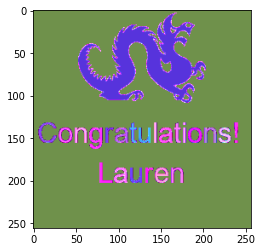

In [23]:
predictions = predictions.detach()
predictions = predictions.to("cpu")
predictions = predictions.reshape((256, 256, 3))
plt.imshow(predictions)